#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим все необходимые для работы библиотеки

In [1]:
import warnings
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6] 

In [2]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV,
                                     train_test_split,
                                     cross_val_score, 
                                     TimeSeriesSplit)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor, cv, train
import lightgbm as lgb
RANDOM_STATE = 12345
warnings.filterwarnings('ignore')

Откроем и изучим файл. Индексами сразу сделаем колонку с датами.

In [3]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим, есть ли пропуски

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, в хронологическом ли порядке расположены индексы

In [7]:
data.index.is_monotonic

True

Сделаем ресемплирование по одному часу.

In [8]:
data = data.resample('1H').sum()

Для работы с временными рядами нам потребовалась небольшая обработка. Мы использовали столбец с датами в качестве индексов, а так же провели ресемрлирование по 1 часу.

## Анализ

Проведем декомпозицию для анализа данных. 

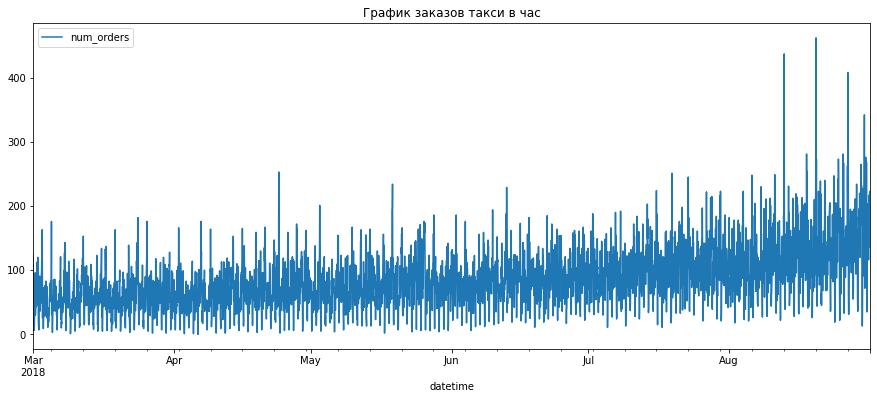

In [9]:
data.plot(title='График заказов такси в час');

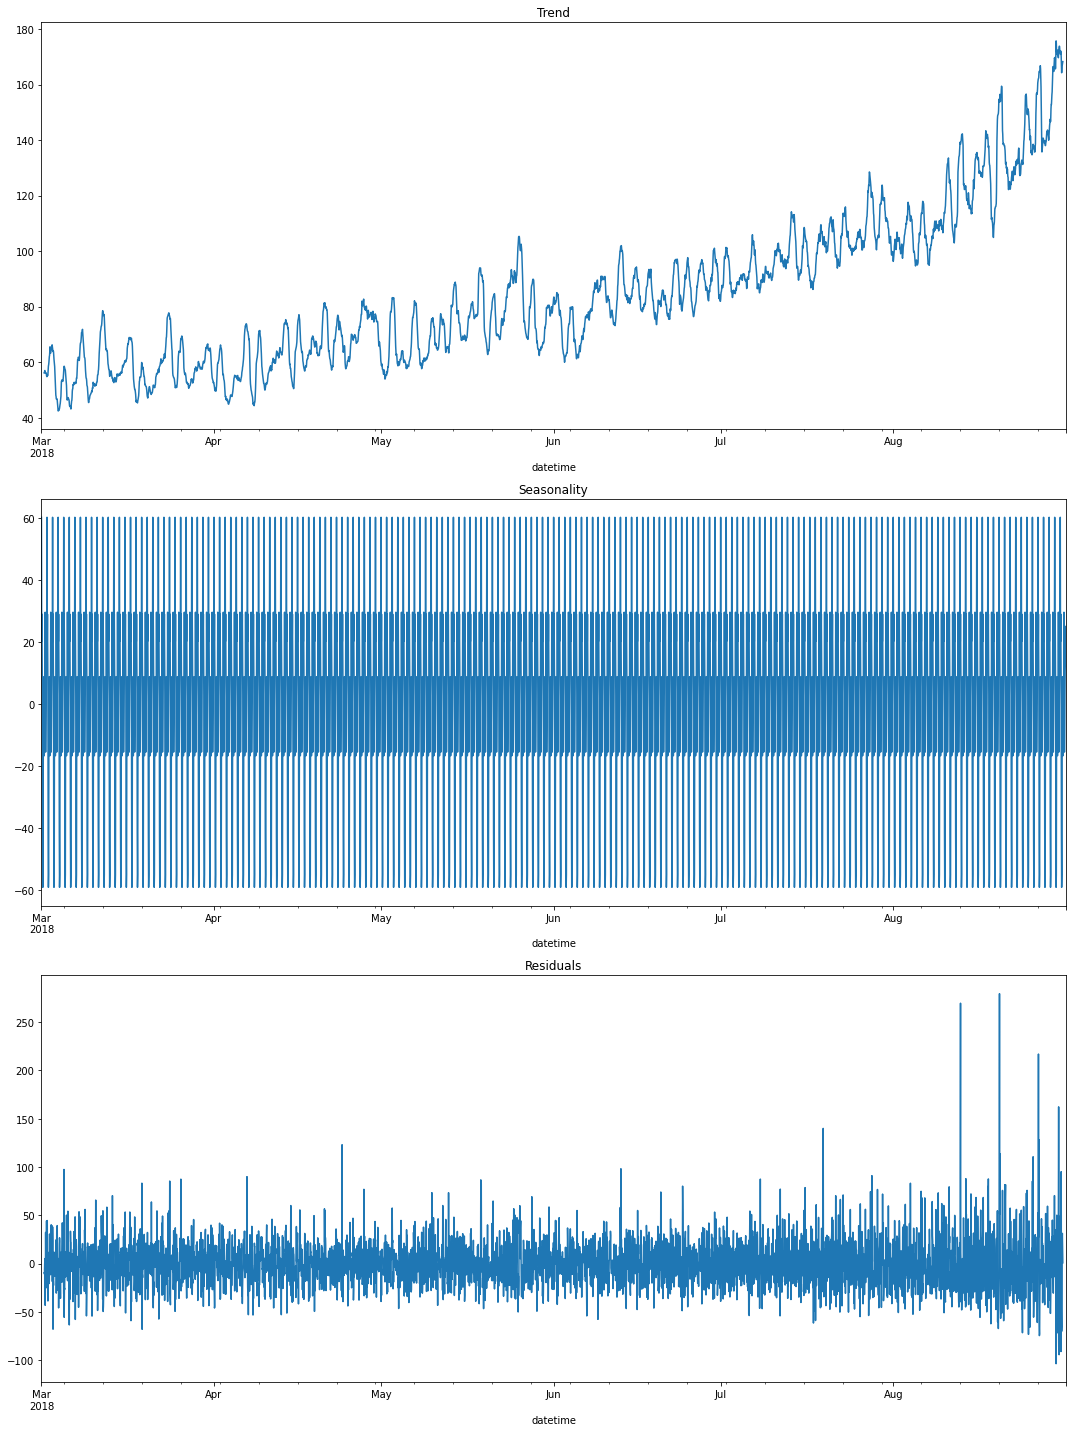

In [10]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим общий тренд на уыелиение колличества заказов. Это может быть связано с различными факторами. По остальным графикам мало что понятно. Попробуем посмотреть меньший период.

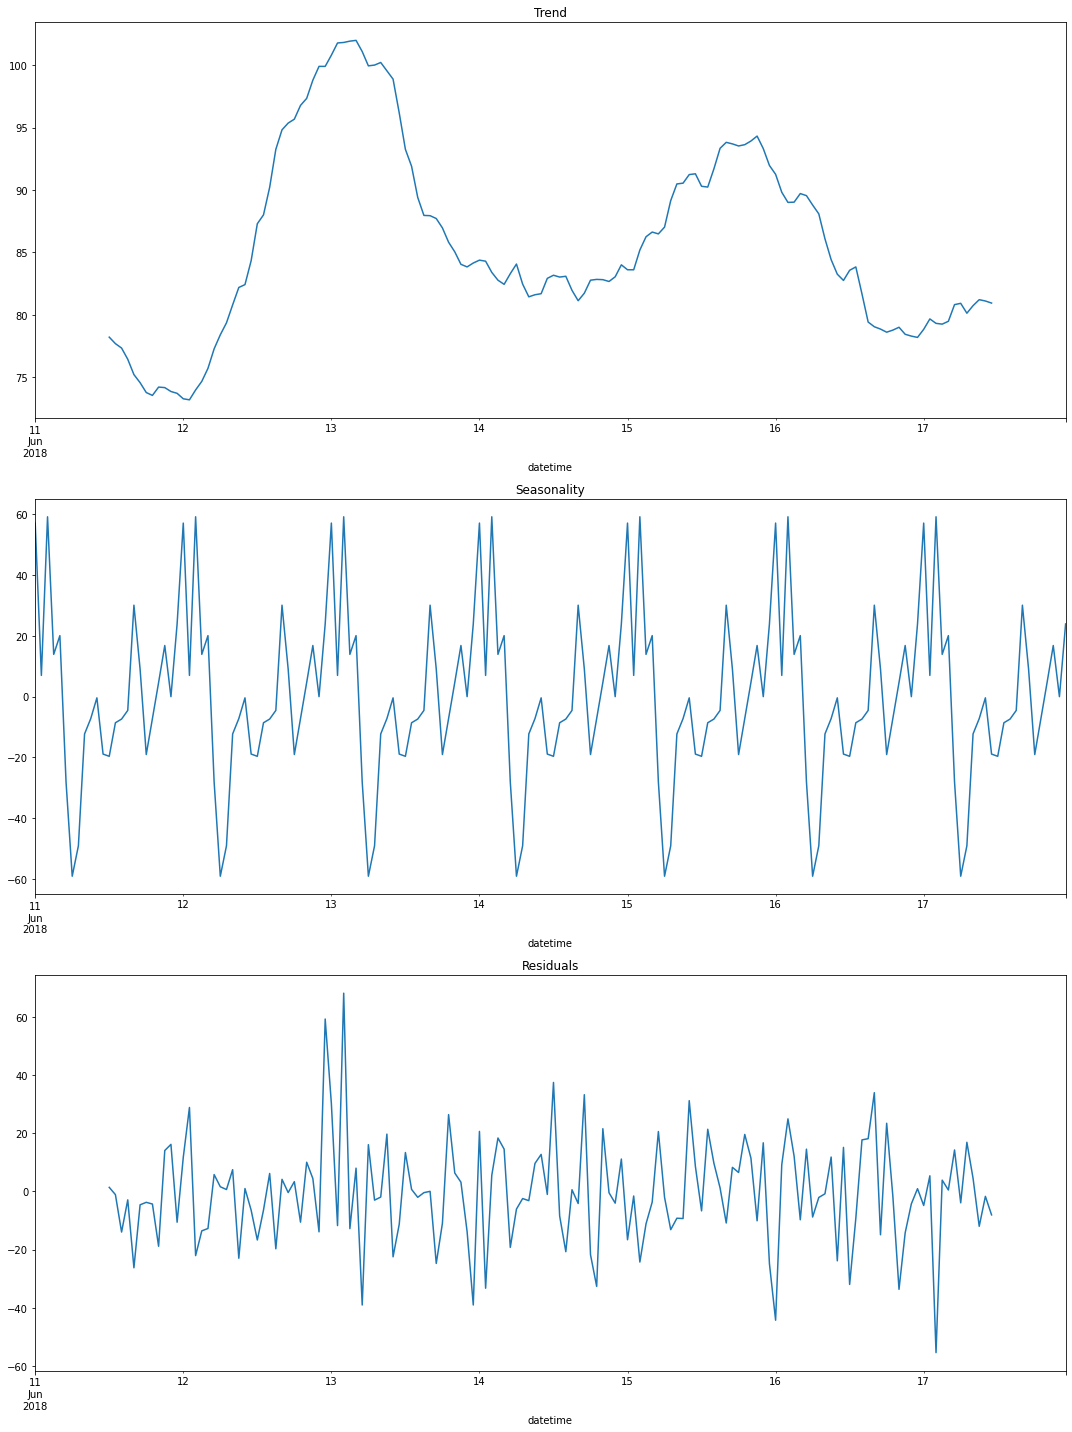

In [11]:
decomposed_new = seasonal_decompose(data['2018-06-11':'2018-06-17'])
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed_new.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_new.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_new.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим некую сезонность, а именно рано утром количество значительно падает.

Посмотрим, есть ли в данных другие сезонности. Проведем ресемплирование по дням и посмотрим, есть ли недельные сезонности

In [12]:
data_day = data.resample('1D').sum()

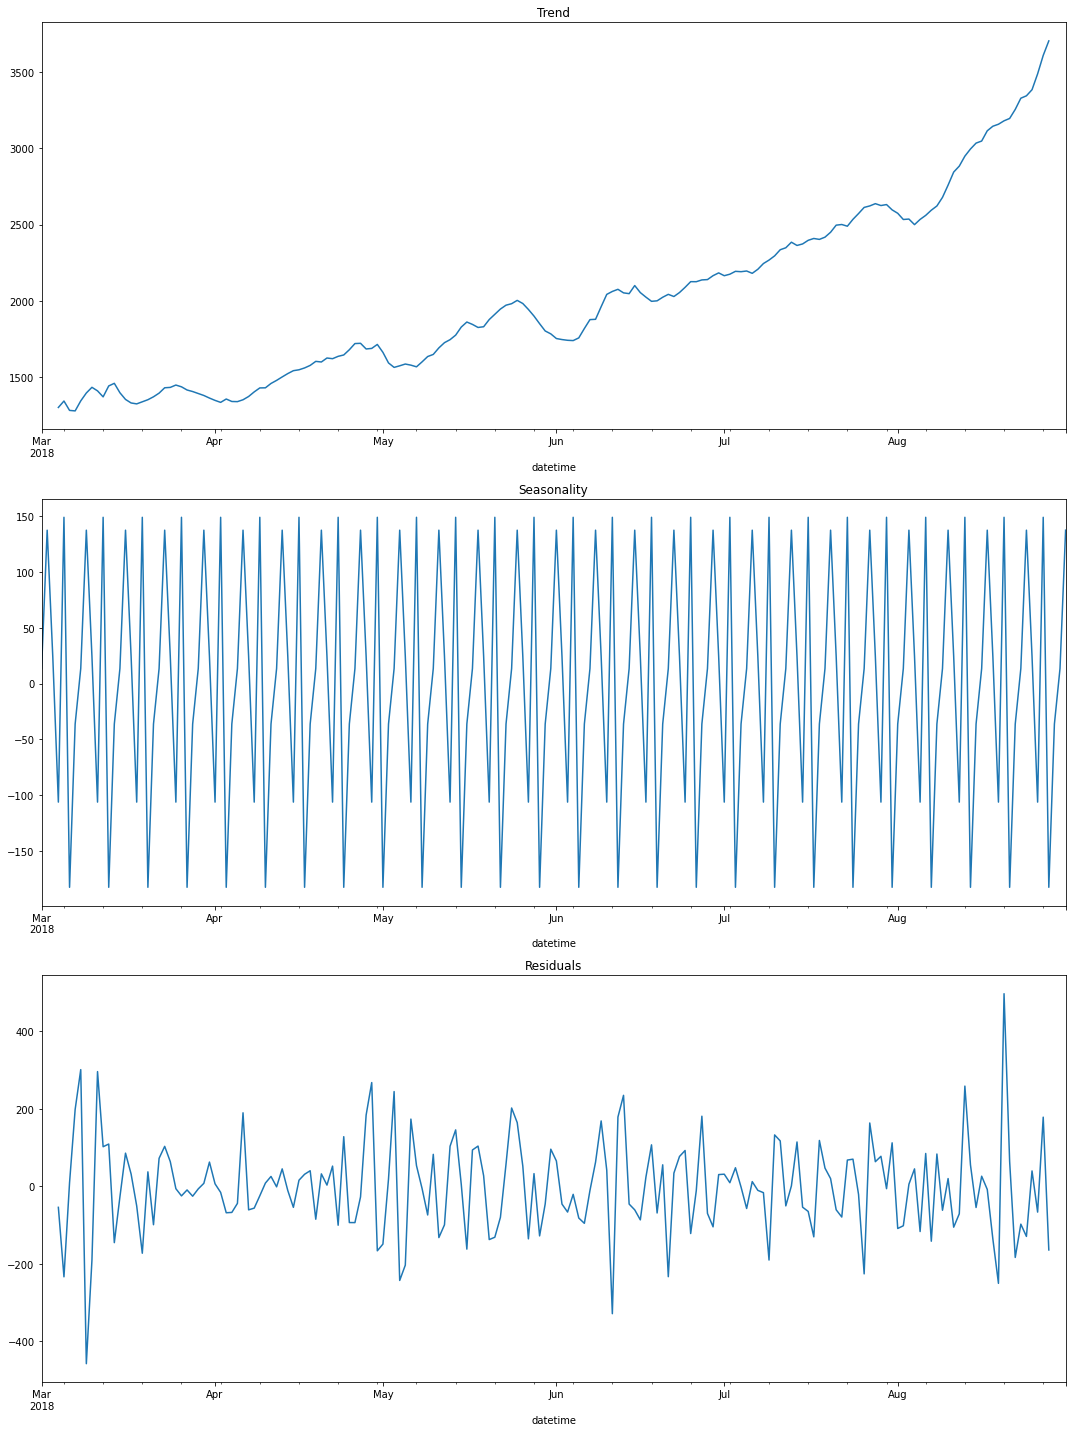

In [13]:
decomposed = seasonal_decompose(data_day['num_orders'])
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

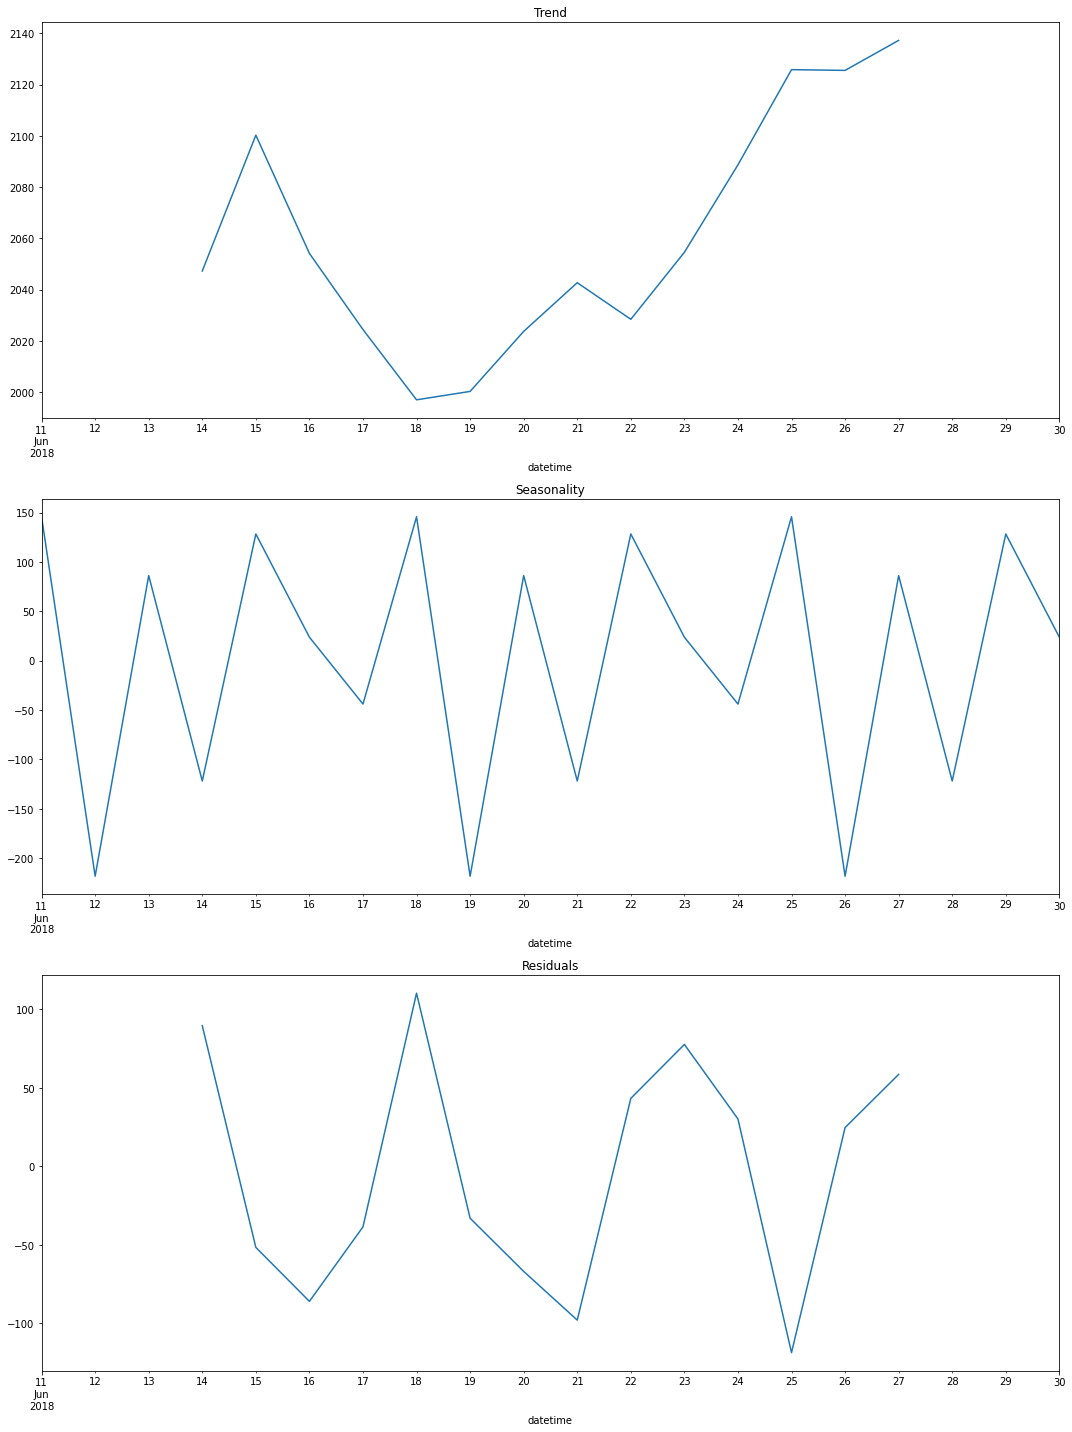

In [14]:
decomposed_new = seasonal_decompose(data_day['2018-06-11':'2018-06-30'])
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed_new.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_new.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_new.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Прослеживается явная недельная сезонность, каждый вторник количество заказов сильно падает. Кроме того видна сезонность каждые 2 дня.

## Обучение

Подберем параметры для 4ех моделей регрессии:

- LinearRegression
- Ridge
- CatBostRegressor
- LGBMRegressor

Так же мы будем подбирать параметры значений для шифтинга и скользящего среднего.

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

## LinearRegression

In [16]:
data_lag = make_features(data, 48, 8)
data_lag = data_lag.dropna()
features = data_lag.drop('num_orders', axis=1)
target = data_lag['num_orders']
features_train, \
features_test, \
target_train, \
target_test = train_test_split(features, 
                               target, 
                               shuffle=False, 
                               test_size=0.1)

In [17]:
tscv = TimeSeriesSplit()
model_lr = LinearRegression()

cv_rmse_lr = (cross_val_score(model_lr, 
                              features_train, 
                              target_train,
                              cv=tscv,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1).mean() * -1)

print(f'CV RMSE LR: {cv_rmse_lr}')

CV RMSE LR: 24.723779388525507


## Ridge

In [19]:
%%time

tscv = TimeSeriesSplit()
model_r = Ridge()
params_gs_r = [{'solver':['auto', 
                          'svd', 
                          'cholesky', 
                          'lsqr', 
                          'sparse_cg', 
                          'sag', 
                          'saga', 
                          'lbfgs'],
               'random_state':[RANDOM_STATE]}]

gs_r = GridSearchCV(model_r, 
                    params_gs_r, 
                    cv=tscv,
                    scoring='neg_root_mean_squared_error')
        
gs_r.fit(features_train, target_train)

gs_r_best_score = gs_r.best_score_ * -1
gs_r_best_params = gs_r.best_params_
            
print('GS RMSE R:', gs_r_best_score)
print(f'best params: {gs_r_best_params}')

GS RMSE R: 24.71450452192962
best params: {'random_state': 12345, 'solver': 'lsqr'}
CPU times: user 2.17 s, sys: 3.4 s, total: 5.58 s
Wall time: 5.6 s


## CatBostRegressor

In [20]:
%%time
tscv = TimeSeriesSplit()
model_cb = CatBoostRegressor(random_state=RANDOM_STATE) 
param_gs_cb = [{'depth':[3, 6],
                'learning_rate': [0.1, 0.2],
                'random_state':[12345],
                'verbose':[False]}]

gs_cb = GridSearchCV(model_cb, 
                    param_gs_cb, 
                    cv=tscv,
                    scoring='neg_root_mean_squared_error', 
                    n_jobs=-1)

gs_cb.fit(features_train, target_train)

gs_cbr_best_score = gs_cb.best_score_ * -1
gs_cbr_best_params = gs_cb.best_params_

print('RMSE:', gs_cbr_best_score)
print(f'best params: {gs_cbr_best_params}')

RMSE: 23.629461895529644
best params: {'depth': 6, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
CPU times: user 2min 10s, sys: 2.31 s, total: 2min 12s
Wall time: 2min 31s


## LGBMRegressor

In [21]:
%%time
tscv = TimeSeriesSplit()
model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', seed=RANDOM_STATE)
param_gs_lgbm = {'learning_rate': [0.0334, 0.1],
                 'n_estimators': range(250, 301, 50)}

gs_lgbm = GridSearchCV(model_lgbm, 
                       param_gs_lgbm, 
                       cv=tscv, 
                       scoring='neg_root_mean_squared_error', 
                       n_jobs=-1)

gs_lgbm.fit(features_train, target_train);

gs_lgbm_best_score = gs_lgbm.best_score_ * -1
gs_lgbm_best_params = gs_lgbm.best_params_

print('RMSE:', gs_lgbm_best_score)
print(f'best params: {gs_lgbm_best_params}')

RMSE: 23.82371305731221
best params: {'learning_rate': 0.0334, 'n_estimators': 300}
CPU times: user 12min 43s, sys: 2.37 s, total: 12min 45s
Wall time: 12min 51s


## Тестирование

## LinearRegression

In [23]:
%%time

model_lr = LinearRegression()

model_lr.fit(features_train, target_train)
model_lr_predict = model_lr.predict(features_test)
LR_RMSE = mean_squared_error(target_test, model_lr_predict) ** 0.5
print('RMSE модели Линейной регрессии:', LR_RMSE)

RMSE модели Линейной регрессии: 42.01004551060757


## Ridge

In [24]:
%%time

model_r = Ridge(random_state=RANDOM_STATE, 
                solver='auto')
        
model_r.fit(features_train, target_train)

model_r_predict = model_r.predict(features_test)
R_RMSE = mean_squared_error(target_test, model_r_predict) ** 0.5
print('RMSE модели Ridge:', R_RMSE)

RMSE модели Ridge: 42.00945179588751


## CatBoostRegressor

In [25]:
%%time

model_cb = CatBoostRegressor(random_state=RANDOM_STATE,
                             depth=6,
                             learning_rate=0.1,
                             verbose=False) 

model_cb.fit(features_train, target_train)
model_cb_predict = model_cb.predict(features_test)
CB_RMSE = mean_squared_error(target_test, model_cb_predict) ** 0.5
print('RMSE модели CatBoostRegressor:', CB_RMSE)

RMSE модели CatBoostRegressor: 39.97884542499528
CPU times: user 12.9 s, sys: 251 ms, total: 13.1 s
Wall time: 14.2 s


## LGBMRegressor

In [26]:
%%time

model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', 
                               seed=RANDOM_STATE,
                               learning_rate=0.0334,
                               n_estimators=300)

model_lgbm.fit(features_train, target_train)
model_lgbm_predict = model_lgbm.predict(features_test)
LGBM_RMSE = mean_squared_error(target_test, model_lgbm_predict) ** 0.5
print('RMSE модели LGBMRegressor:', LGBM_RMSE)

RMSE модели LGBMRegressor: 39.43418700494345
CPU times: user 39.2 s, sys: 176 ms, total: 39.4 s
Wall time: 39.6 s


In [27]:
columns = ['model', 'training_RMSE', 'test_RMSE']
LR = ['LinearRegression', cv_rmse_lr, LR_RMSE]
R = ['Ridge', gs_r_best_score, R_RMSE]
CBT = ['CatBoostRegressor', gs_cbr_best_score, CB_RMSE]
LGBMR = ['LGBMRegressor', gs_lgbm_best_score, LGBM_RMSE]

table = pd.DataFrame([LR, 
                      R, 
                      CBT, 
                      LGBMR], columns = columns)

table = table.sort_values(by='test_RMSE', ascending=True)

display(table)

,model,training_RMSE,test_RMSE
3,LGBMRegressor,23.823713,39.434187
2,CatBoostRegressor,23.629462,39.978845
1,Ridge,24.714505,42.009452
0,LinearRegression,24.723779,42.010046


На тренировочной выборке лучший RMSE у LGBMRegressor. На тестовой выборке лучше всего себя показал CatBoostRegressor.

Вывод. Нам было необходимо спрогнозировать количество заказов такси на следующий час.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
Для достижения поставленной цели мы прошли следующие этапы:
- Загрузили данные и выполнили их ресемплирование по одному часу.
- Проанализировали данные. Явно виден общий тренд на увеличение количества заказов, так же заметно сильное снижение заказов в утренние часы, резкое уменьшение заказов по вторникам и сезонность каждые 2 дня.
- Мы обучили 4 модели с различными гиперпараметрами: LinearRegression, Ridge, CatBoostRegressor, LGBMRegressor. Лучще всего себя показала CatBoostRegressor.
- Проверили данные на тестовой выборке. Самая лучшая оказалась LGBMRegressor - RMSE = 39.434187. Задача стояла достичь RMSE на тестовой выборке ниже 48. 